In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow import feature_column
import os

In [2]:
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv(
    '../data/ml-100k/ml-100k/u.user', sep='|', names=users_cols, encoding='latin-1')

ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv(
    '../data/ml-100k/ml-100k/u.data', sep='\t', names=ratings_cols, encoding='latin-1')

# The movies file contains a binary feature for each genre.
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "SciFi", "Thriller", "War", "Western"
]
movies_cols = [
    'movie_id', 'title', 'release_date', "video_release_date", "imdb_url"
] + genre_cols
movies = pd.read_csv(
    '../data/ml-100k/ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')

# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: str(x-1))
movies["movie_id"] = movies["movie_id"].apply(lambda x: str(x-1))
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: str(x-1))
ratings["user_id"] = ratings["user_id"].apply(lambda x: str(x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

# Since some movies can belong to more than one genre, we create different
# 'genre' columns as follows:
# - all_genres: all the active genres of the movie.
# - genre: randomly sampled from the active genres.
def mark_genres(movies, genres):
    def get_random_genre(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return np.random.choice(active)
    def get_all_genres(gs):
        active = [genre for genre, g in zip(genres, gs) if g==1]
        if len(active) == 0:
            return 'Other'
        return '-'.join(active)
    movies['genre'] = [
          get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
    movies['all_genres'] = [
          get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

# Create one merged DataFrame containing all the movielens data.
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')

In [3]:
movies[["movie_id", "title", "release_date", "video_release_date", "imdb_url", "year", "genre", "all_genres"]].head(3)

,movie_id,title,release_date,video_release_date,imdb_url,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Children,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,1995,Adventure,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,1995,Thriller,Thriller


In [4]:
ratings = ratings.merge(movies[["movie_id", "title", "release_date", "video_release_date", "imdb_url", "year", "genre", "all_genres"]], 
                                  how='inner',
                                  left_on="movie_id",
                                  right_on="movie_id",
                                  sort="movie_id")

ratings.head(5)

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,year,genre,all_genres
0,307,0,4.0,887736532,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Children,Animation-Children-Comedy
1,286,0,5.0,875334088,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Children,Animation-Children-Comedy
2,147,0,4.0,877019411,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Children,Animation-Children-Comedy
3,279,0,4.0,891700426,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Children,Animation-Children-Comedy
4,65,0,3.0,883601324,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,1995,Children,Animation-Children-Comedy


In [5]:
user_watched = ratings.groupby(["user_id"])["movie_id"].apply(lambda x: list(x))
user_watched = user_watched.tolist()

In [6]:
user_watched_describe = ratings["user_id"].value_counts()
user_watched_describe.to_frame().describe()

,user_id
count,943.000000
mean,106.044539
std,100.931743
min,20.000000
25%,33.000000
50%,65.000000
75%,148.000000
max,737.000000


In [7]:
user_watched[0].__len__()

272

In [8]:
" ".join(user_watched[0])

'0 1 10 100 101 102 103 104 105 106 107 108 109 11 110 111 112 113 114 115 116 117 118 119 12 120 121 122 123 124 125 126 127 128 129 13 130 131 132 133 134 135 136 137 138 139 14 140 141 142 143 144 145 146 147 148 149 15 150 151 152 153 154 155 156 157 158 159 16 160 161 162 163 164 165 166 167 168 169 17 170 171 172 173 174 175 176 177 178 179 18 180 181 182 183 184 185 186 187 188 189 19 190 191 192 193 194 195 196 197 198 199 2 20 200 201 202 203 204 205 206 207 208 209 21 210 211 212 213 214 215 216 217 218 219 22 220 221 222 223 224 225 226 227 228 229 23 230 231 232 233 234 235 236 237 238 239 24 240 241 242 243 244 245 246 247 248 249 25 250 251 252 253 254 255 256 257 258 259 26 260 261 262 263 264 265 266 267 268 269 27 270 271 28 29 3 30 31 32 33 34 35 36 37 38 39 4 40 41 42 43 44 45 46 47 48 49 5 50 51 52 53 54 55 56 57 58 59 6 60 61 62 63 64 65 66 67 68 69 7 70 71 72 73 74 75 76 77 78 79 8 80 81 82 83 84 85 86 87 88 89 9 90 91 92 93 94 95 96 97 98 99'

In [9]:
def create_sequence(seq, maxlen=11, window=5):
    seqs = list()
    for i in range(0, (len(seq)//maxlen + 1)):
        if i + 20 < len(seq):
            seqs.append(seq[i*window: (i*window) + maxlen])
        else:
            seqs.append(seq[-maxlen:])
    return seqs

In [10]:
dataset = list()
for seq in user_watched:
    dataset += create_sequence(seq)

In [11]:
vocabs = sorted(ratings["movie_id"].unique())
item2dix = preprocessing.StringLookup(vocabulary=vocabs)
item2dix.adapt(dataset)
item2idx_test = item2dix(dataset[0])
item2idx_test

<tf.Tensor: shape=(11,), dtype=int64, numpy=array([ 67, 232, 152, 300, 330, 591, 837, 239, 226, 297, 237], dtype=int64)>

In [12]:
idx2item = preprocessing.StringLookup(vocabulary=item2dix.get_vocabulary(), invert=True)

idx2item(item2idx_test)

<tf.Tensor: shape=(11,), dtype=string, numpy=
array([b'0', b'1', b'10', b'100', b'101', b'102', b'103', b'104', b'105',
       b'106', b'107'], dtype=object)>

In [13]:
dstf = item2dix(dataset)
sequence = tf.data.Dataset.from_tensor_slices(dstf)

In [14]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [15]:
sequence = sequence.map(split_input_target)

In [16]:
for seq in sequence.take(1):
    print(seq)

(<tf.Tensor: shape=(10,), dtype=int64, numpy=array([ 67, 232, 152, 300, 330, 591, 837, 239, 226, 297], dtype=int64)>, <tf.Tensor: shape=(10,), dtype=int64, numpy=array([232, 152, 300, 330, 591, 837, 239, 226, 297, 237], dtype=int64)>)


In [17]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

sequence = (
    sequence
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

sequence

<PrefetchDataset shapes: ((64, 10), (64, 10)), types: (tf.int64, tf.int64)>

In [18]:
# Length of the vocabulary in chars
vocab_size = len(vocabs)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

class MyModel(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, rnn_units):
        super().__init__(self)
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(rnn_units,
                                       return_sequences=True,
                                       return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, inputs, states=None, return_state=False, training=False):
        x = inputs
        x = self.embedding(x, training=training)
        if states is None:
            states = self.gru.get_initial_state(x)
        x, states = self.gru(x, initial_state=states, training=training)
        x = self.dense(x, training=training)

        if return_state:
            return x, states
        else:
            return x

In [19]:
model = MyModel(
        # Be sure the vocabulary size matches the `StringLookup` layers.
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        rnn_units=rnn_units
)

In [20]:
for input_example_batch, target_example_batch in sequence.take(1):
    print(input_example_batch)
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

tf.Tensor(
[[ 574   45  762  900   80  105   16   47   86  168]
 [  10   84    9   24   71   96  127   23   63   81]
 [ 317  103  204  390  200  257  669 1180  511  349]
 [  16    9   24    7  156    5   13  110  141  106]
 [  35  150   11   98  261  224   45  229   47  168]
 [ 318  343  587   18  368   35  442  268   95    8]
 [  46  120  102  149    5  142   50  106  446  262]
 [ 138   37   66   88  203  126  207   29  147  104]
 [  65  178   28   78   14  260   15   21   62   22]
 [  12  119    2   25   46   37   88   29   44   20]
 [ 506    3   81   39   56  307   13   92  193  158]
 [  38  167  199   45   80   16  192   47   86   53]
 [ 209   72   15   21   68  121  143   62   22   89]
 [ 127   90  243   51   32   63   27  146   64    6]
 [  52   25   66  147  178   15   79   61    9  108]
 [  75   41  161  201  190  135  145  106   92  202]
 [ 277  490  379  315  400   11  129   77  236  245]
 [  54   51   32   63   81   27  222  350  186   93]
 [  88  126   29  104   44   20   3

In [21]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([ 447,  387, 1156,  939, 1164, 1188,  345,  343, 1055,  451],
      dtype=int64)

In [22]:
print("Input:\n", idx2item(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", idx2item(sampled_indices).numpy())

Input:
 [b'1424' b'143' b'1437' b'1442' b'146' b'149' b'150' b'152' b'153' b'154']

Next Char Predictions:
 [b'1477' b'1198' b'70' b'1606' b'615' b'1672' b'1125' b'1135' b'1466'
 b'677']


In [23]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 10, 1682)  # (batch_size, sequence_length, vocab_size)
Mean loss:         7.4280367


In [24]:
model.compile(optimizer='adam', loss=loss)

In [25]:
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [26]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  430592    
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense (Dense)                multiple                  1724050   
Total params: 6,092,946
Trainable params: 6,092,946
Non-trainable params: 0
_________________________________________________________________


In [27]:
EPOCHS = 20

history = model.fit(sequence, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
149/149 [==============================] - 57s 368ms/step - loss: 6.0012
Epoch 2/20
149/149 [==============================] - 54s 365ms/step - loss: 2.8423
Epoch 3/20
149/149 [==============================] - 55s 366ms/step - loss: 2.4014
Epoch 4/20
149/149 [==============================] - 55s 366ms/step - loss: 2.2152
Epoch 5/20
149/149 [==============================] - 56s 375ms/step - loss: 2.0445
Epoch 6/20
149/149 [==============================] - 58s 389ms/step - loss: 1.8956
Epoch 7/20
149/149 [==============================] - 56s 373ms/step - loss: 1.7573
Epoch 8/20
149/149 [==============================] - 56s 375ms/step - loss: 1.6041
Epoch 9/20
149/149 [==============================] - 55s 371ms/step - loss: 1.4714
Epoch 10/20
149/149 [==============================] - 55s 371ms/step - loss: 1.3329
Epoch 11/20
149/149 [==============================] - 59s 399ms/step - loss: 1.1936
Epoch 12/20
149/149 [==============================] - 61s 411ms/step - lo

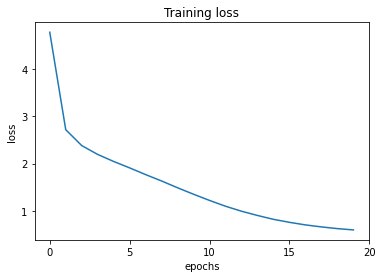

In [33]:
import matplotlib.pyplot as plt

plt.plot(history.history["loss"])
plt.title("Training loss")
plt.xticks([i for i in range(0, 21, 5)])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [34]:
for input_example_batch, target_example_batch in sequence.take(1):
    print(input_example_batch)
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

tf.Tensor(
[[ 138   66   88  126   20   15   21  101  102   42]
 [  97  105   16    2   96  127   27   87    7    6]
 [  10   91    9   24    3   34   39   93   87    5]
 [ 486  661   99  175   77   38  167  690  192   86]
 [ 111  307  103  191  354  219  164  482  293  188]
 [ 114   30   40   54   32   85    5   50  103  295]
 [  39   93    7   56    5   13   41  161  190  135]
 [ 490  162   18   95    8  100  173   11  129   99]
 [  95 1063  740  638  816  891  134   51   39   27]
 [   4   26  119  124   59   58    2   52   25  138]
 [ 584   99   48  472   98   77  791   38   97  261]
 [ 110   92   82  128  465  607 1311  398  666 1010]
 [ 155  129   99   31   16    2   10  108   24  263]
 [  72   15   22  166    9   40  109   24  198   23]
 [ 149   71    3   54   32   27  186  146   64    7]
 [  71    3  116    6  171    5  221   13  142  106]
 [  97   55   45   47  159  112   19   12   17    4]
 [  74   15   21   68  143   22   10  151  101  102]
 [ 108   24   96   73  267   23    

In [35]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()
sampled_indices

array([ 37,  29, 126,  29,  15,  21, 101, 102,  42,  91], dtype=int64)

In [36]:
print("Input:\n", idx2item(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", idx2item(sampled_indices).numpy())

Input:
 [b'183' b'186' b'187' b'189' b'194' b'209' b'21' b'225' b'226' b'227']

Next Char Predictions:
 [b'185' b'190' b'189' b'190' b'209' b'21' b'225' b'226' b'227' b'228']


In [39]:
idx2item(target_example_batch[0]).numpy()

array([b'186', b'187', b'189', b'194', b'209', b'21', b'225', b'226',
       b'227', b'228'], dtype=object)